In [79]:
import re
from glob import iglob, glob
import matplotlib.pyplot as plt
from astropy.io import ascii, fits
from astropy.stats import sigma_clip
from lightkurve import MPLSTYLE
from lightkurve import open as open_lc
from lightkurve.utils import running_mean as RunningMean
import numpy as np
from scipy.signal import argrelmax
from scipy.stats import median_absolute_deviation
from LCFeatureExtraction import error_estimate, amplitude_estimate
from usefulFuncs import decode_filename, ifind_tpfs
from k2spin import prot

In [122]:
# Parameters
outlier_sigma = 3.0
flatten_window = 321

# Import target list
targets = ascii.read('DataInput/cluster_targets_tic.ecsv')

# Get filepaths to LightCurve FITS
src_lcfs = 'LightCurvesFITS/*.fits'
fits_paths = glob(src_lcfs)

# Get sample target pixel file
sample_tpf = next(ifind_tpfs())

# Get quality mask
with fits.open('DataInput/ClusterQuality/Sector8_Sample.fits.gz') as quality_sample:
    # For Chelsea's quality flags:
    #   0 means good, 1 means bad
    quality_flags = quality_sample[1].data['quality']
    good_mask = ~quality_flags.astype(bool)

# Reduce quality mask to match light curves
short_quality = good_mask[sample_tpf.hdu[1].data['quality'] != 32]
    
# Get sample light curve
fits_path = fits_paths[39]

# Import sample FITS Light Curve, remove outliers, and long term trends
ticid, ap_type = decode_filename(fits_path)
lcf = open_lc(fits_path)
lc = lcf.get_lightcurve('FLUX')
cleared_lc = lc.remove_outliers(sigma=outlier_sigma)
flatten_lc, trend_lc = cleared_lc.flatten(flatten_window, return_trend=True, polyorder=2)

# Estimate Features
sigma = error_estimate(flatten_lc, quality=short_quality)
amplitude = amplitude_estimate(flatten_lc, quality=short_quality)
print(f'Sigma \t\t= {sigma:.1f} ppm')
print(f'Amplitude \t= {amplitude:.3f}')

Sigma 		= 1026.5 ppm
Amplitude 	= 0.013


Sigma 		= 601.3 ppm
Amplitude 	= 0.021


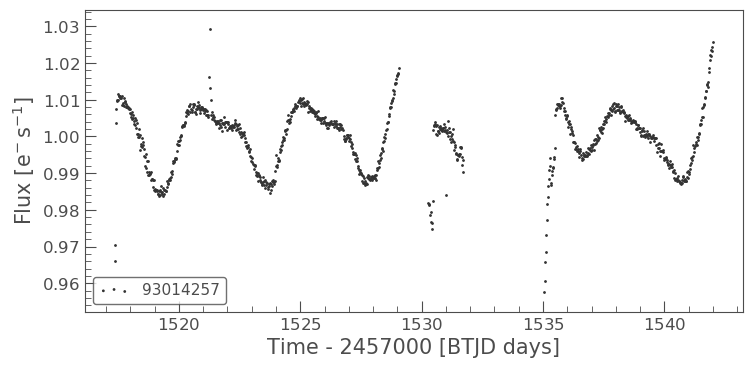

In [123]:
for fits_path in fits_paths:
    if '93014257' in fits_path:
        break

# Import sample FITS Light Curve, remove outliers, and long term trends
ticid, ap_type = decode_filename(fits_path)
lcf = open_lc(fits_path)
lc = lcf.get_lightcurve('FLUX')
cleared_lc = lc.remove_outliers(sigma=outlier_sigma)
flatten_lc, trend_lc = cleared_lc.flatten(flatten_window, return_trend=True, polyorder=2)

# Estimate Features
sigma = error_estimate(flatten_lc)
amplitude = amplitude_estimate(flatten_lc)
print(f'Sigma \t\t= {sigma:.1f} ppm')
print(f'Amplitude \t= {amplitude:.3f}')
flatten_lc.scatter()

In [139]:
sigmas = np.zeros(len(fits_paths))
amplitudes = np.zeros(len(fits_paths))

for i, fits_path in enumerate(fits_paths):
    # Import and Prepare light curve
    ticid, ap_type = decode_filename(fits_path)
    lightcurve = open_lc(fits_path).get_lightcurve('FLUX').remove_outliers(sigma=outlier_sigma).flatten(flatten_window)
    
    # Estimate Features
    if lightcurve.flux.size == short_quality.size:    
        sigmas[i] = error_estimate(lightcurve, quality=short_quality)
        amplitudes[i] = amplitude_estimate(lightcurve, quality=short_quality) / (sigmas[i] / 1e6)
    else:
        sigmas[i] = error_estimate(lightcurve)
        amplitudes[i] = amplitude_estimate(lightcurve) / (sigmas[i] / 1e6)

Upper Right corner - Best
Lower left corner - Worst


/Users/joseperez/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


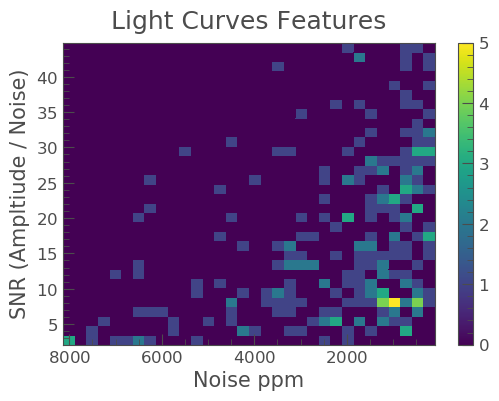

In [142]:
# Plot frequency distribution using histogram
clipped_sigmas = sigma_clip(sigmas, sigma=3)
clipped_amplitudes = sigma_clip(amplitudes)
outliers = clipped_amplitudes.mask | clipped_sigmas.mask
index = np.where(outliers)[0]

with plt.style.context(MPLSTYLE):
    plt.figure(figsize=(6,4))
    plt.hist2d(sigmas[~outliers], amplitudes[~outliers], bins=32)
    # plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()

    plt.title("Light Curves Features")
    plt.xlabel('Noise ppm')
    plt.ylabel('SNR (Ampltiude / Noise)')
    plt.margins(0)
    plt.colorbar()

    # Display the histogram
    print('Upper Right corner - Best')
    print('Lower left corner - Worst')
    plt.show()

/Users/joseperez/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
/Users/joseperez/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
/Users/joseperez/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
/Users/joseperez/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
/Users/joseperez/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
/Users/joseperez/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.

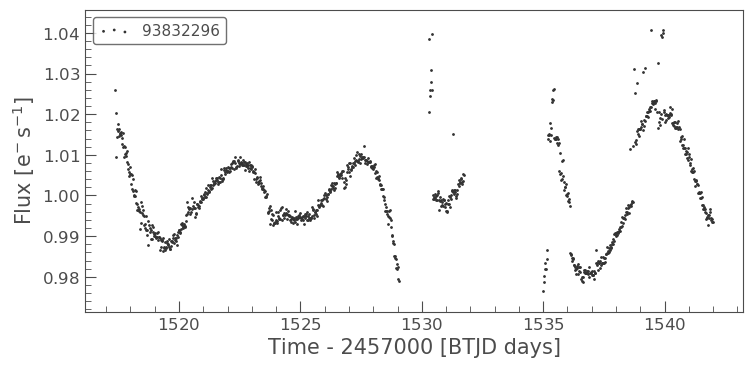

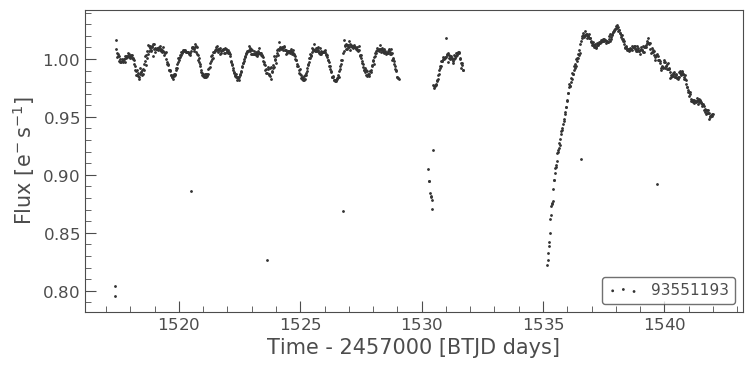

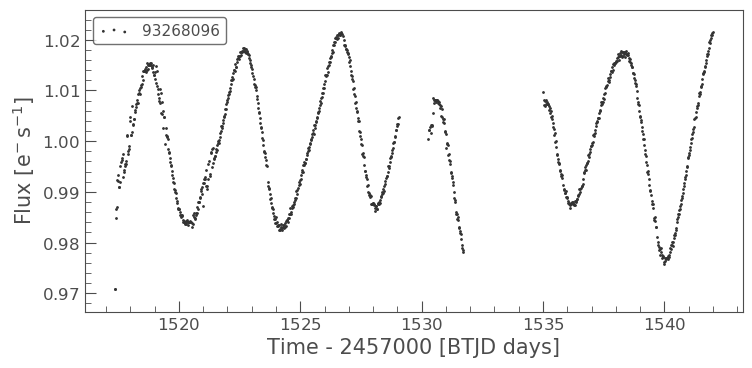

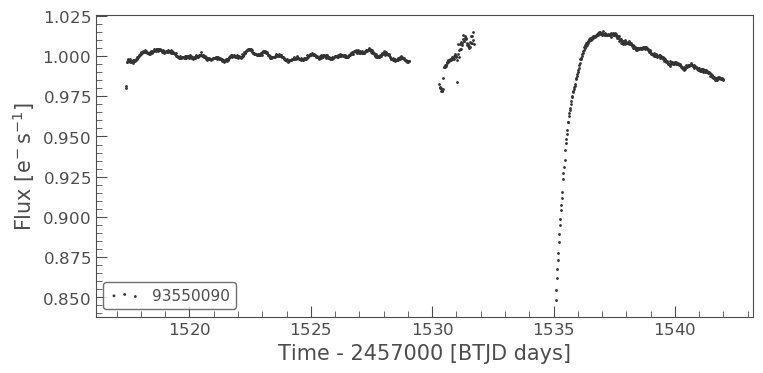

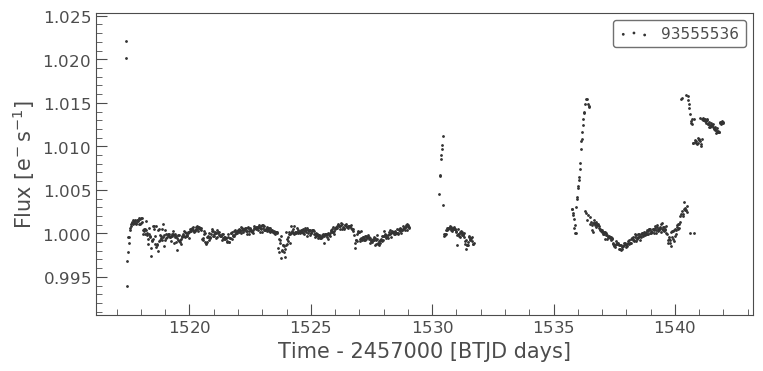

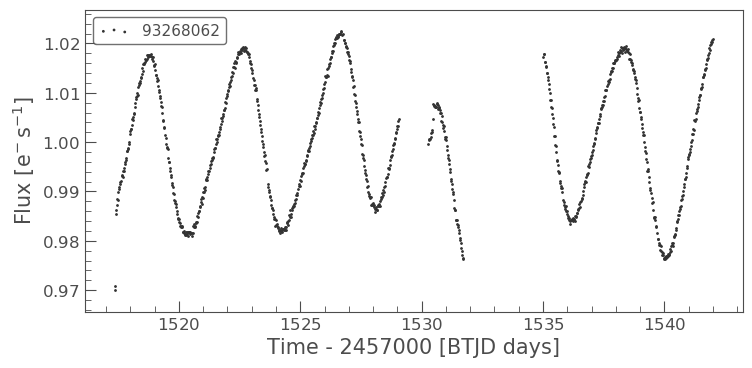

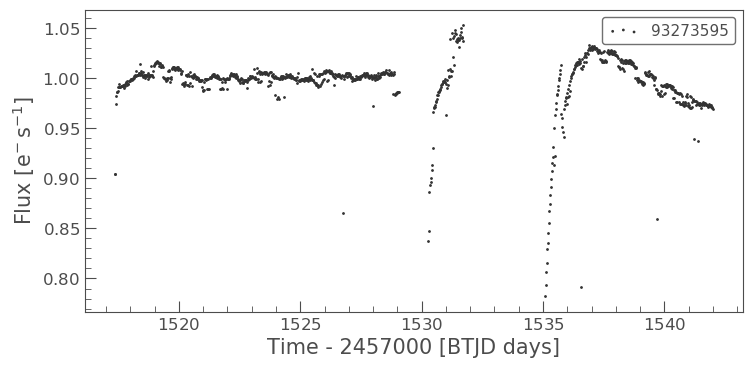

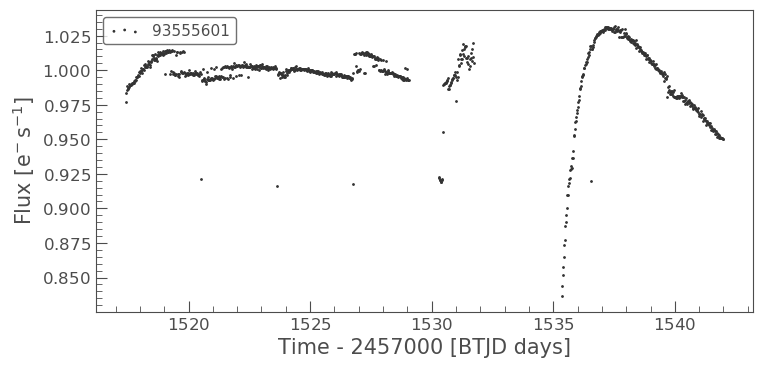

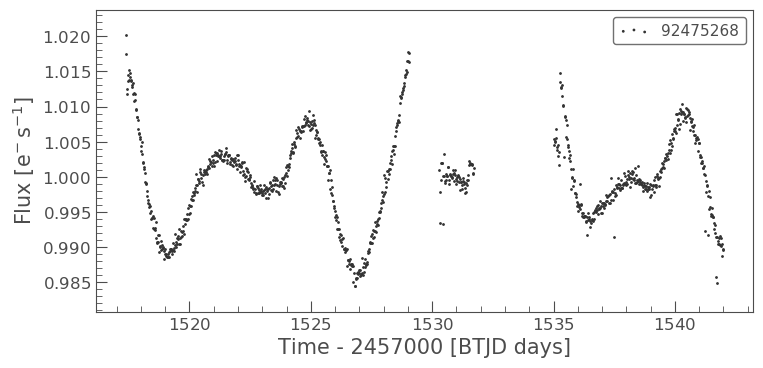

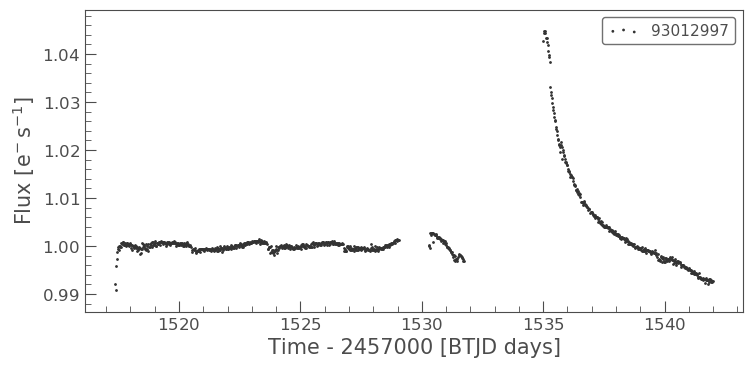

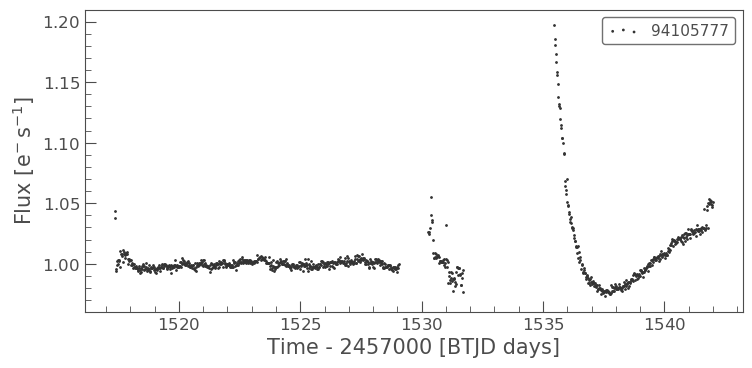

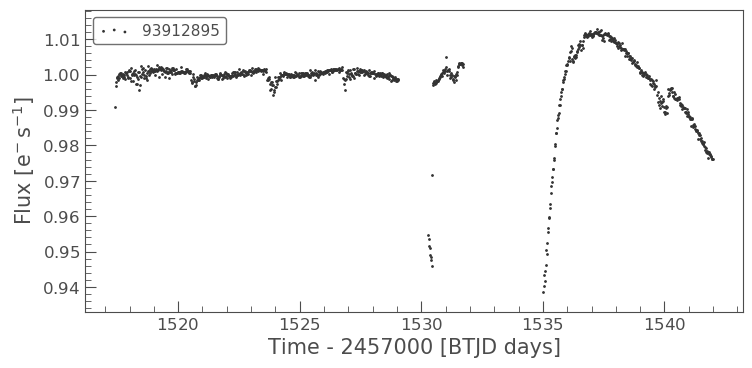

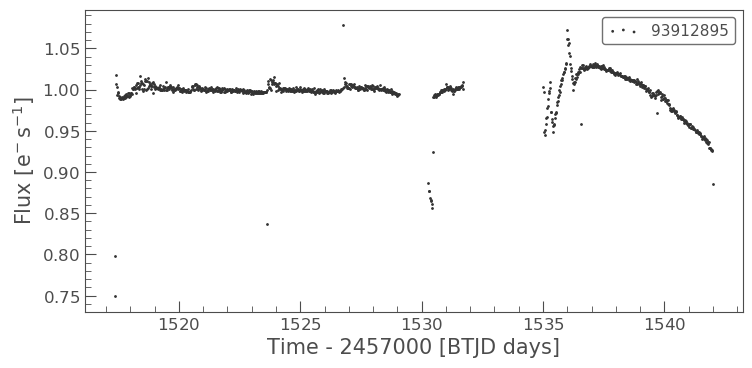

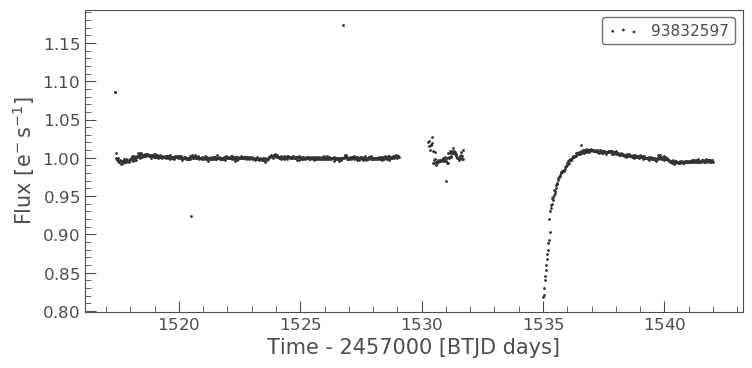

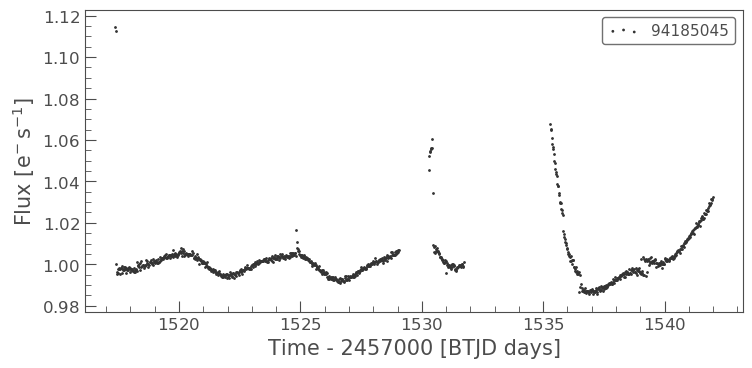

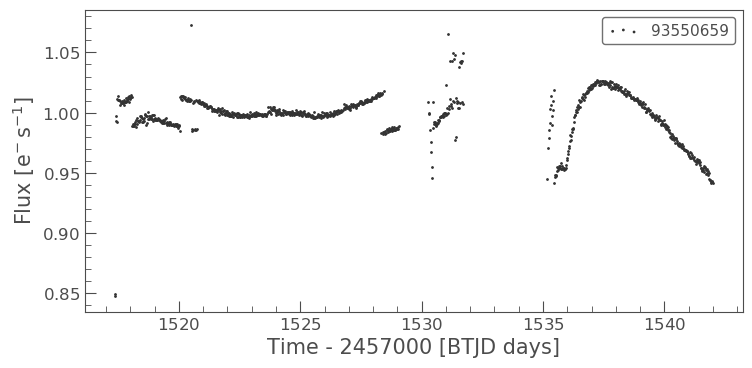

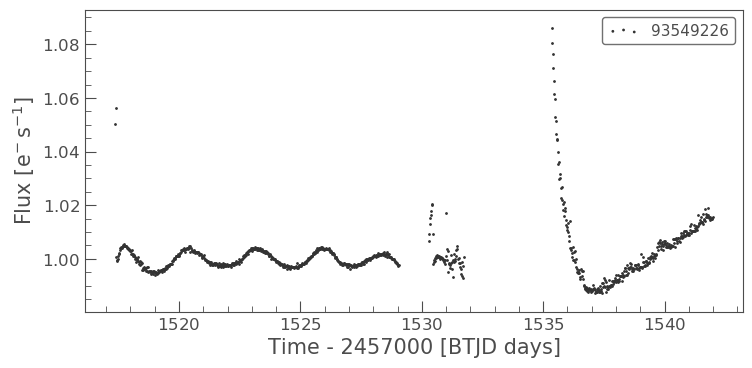

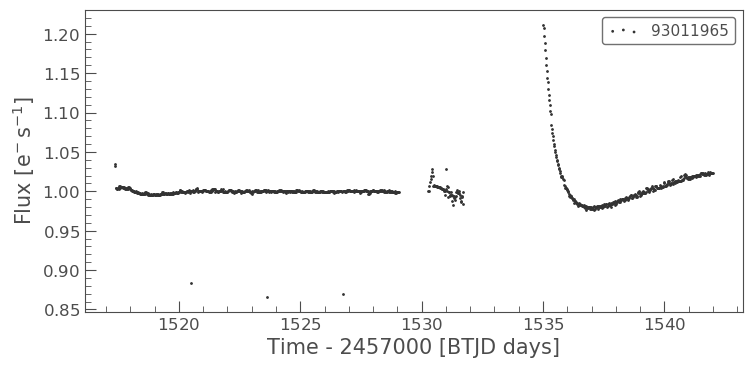

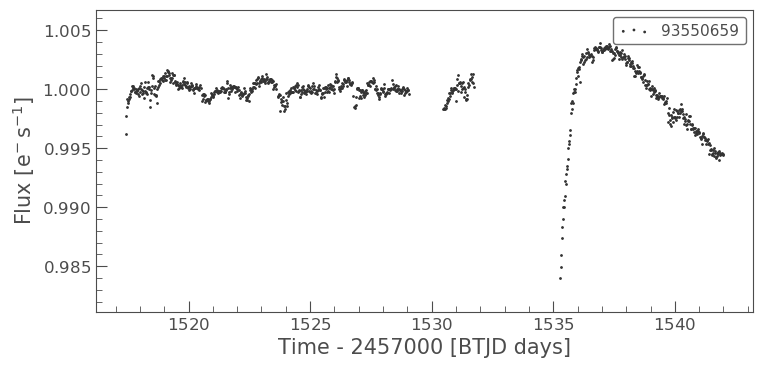

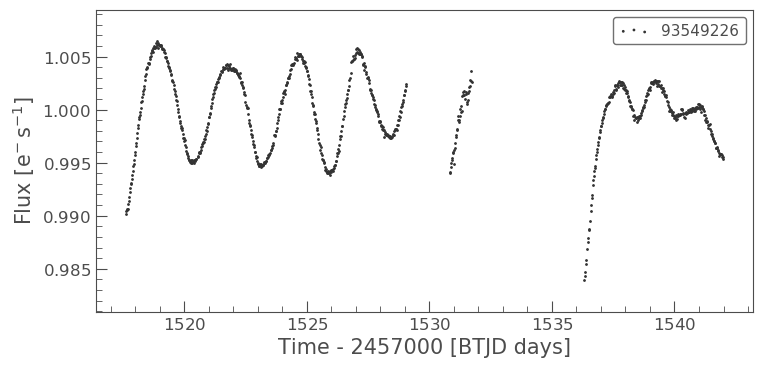

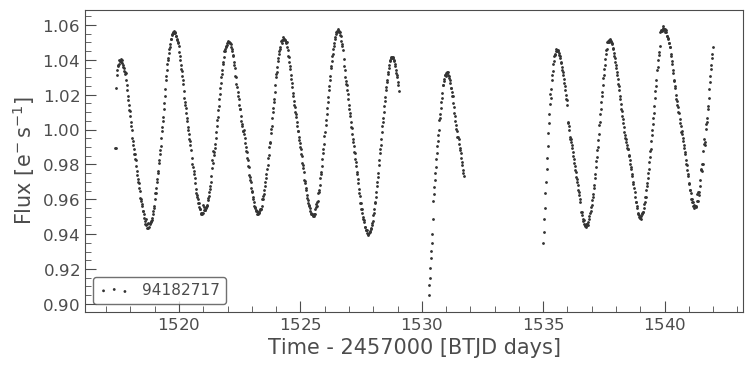

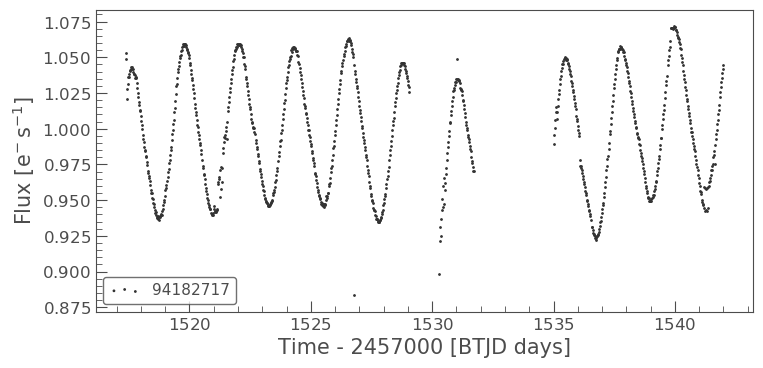

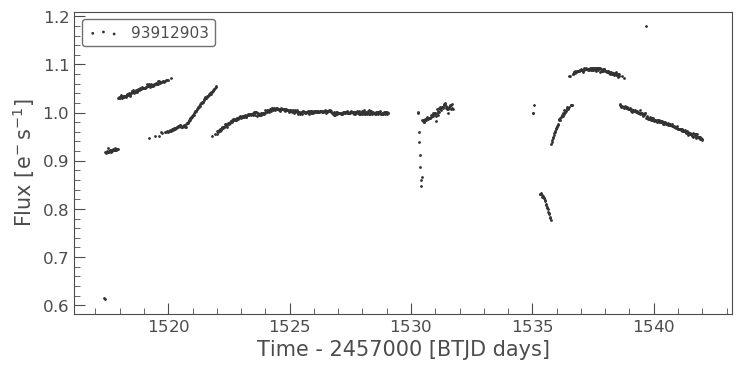

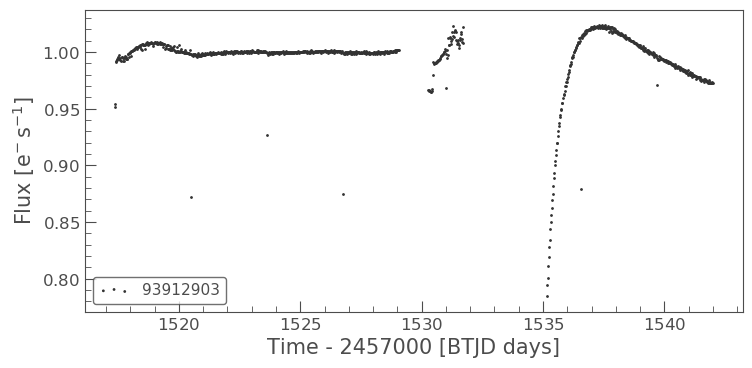

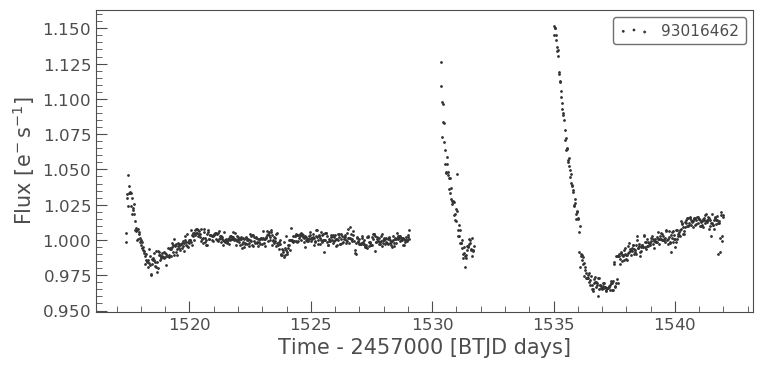

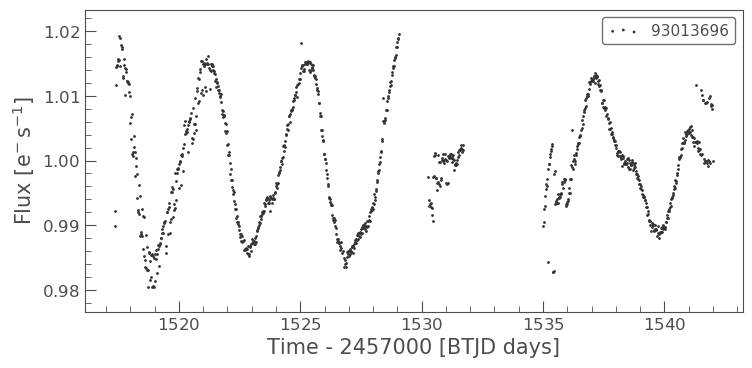

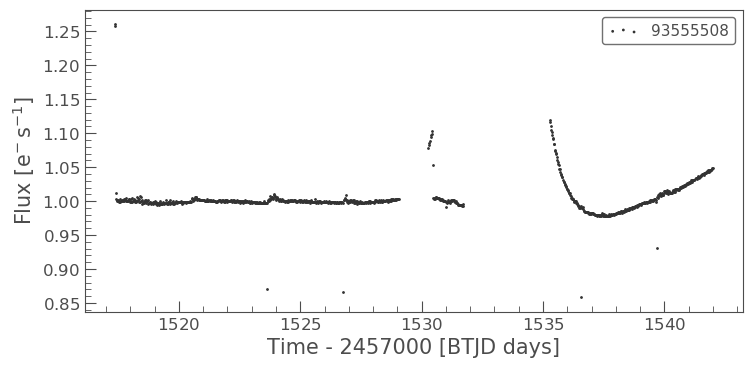

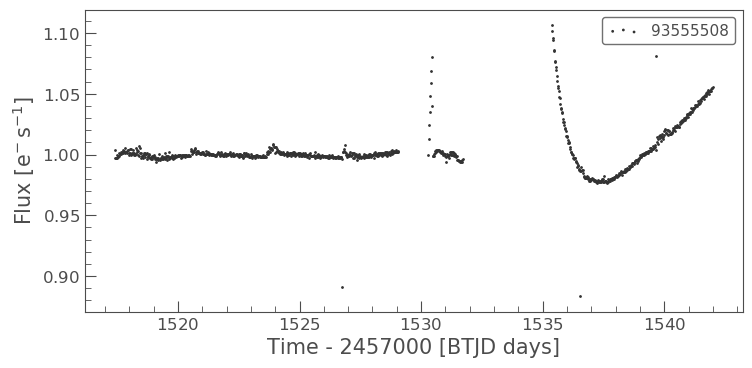

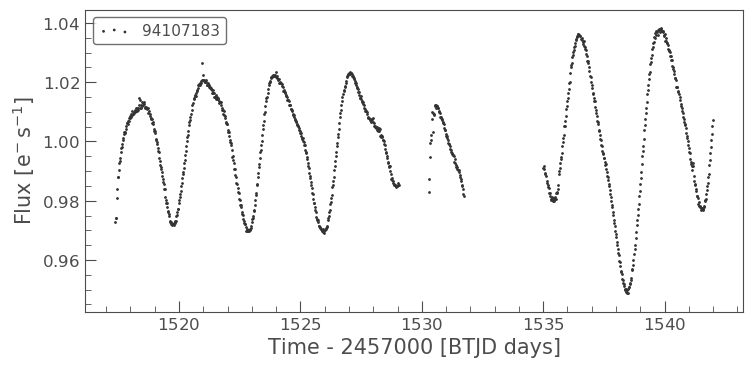

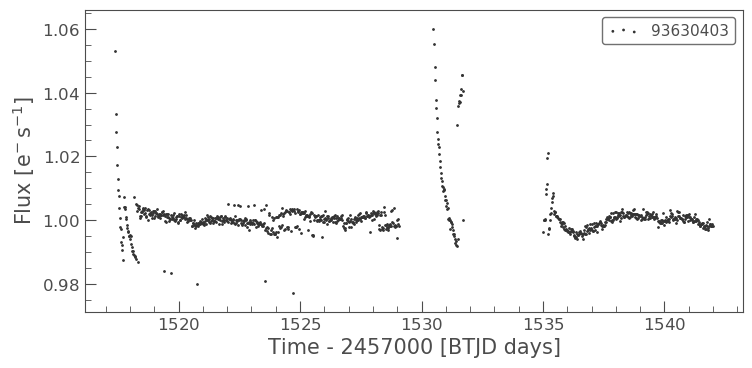

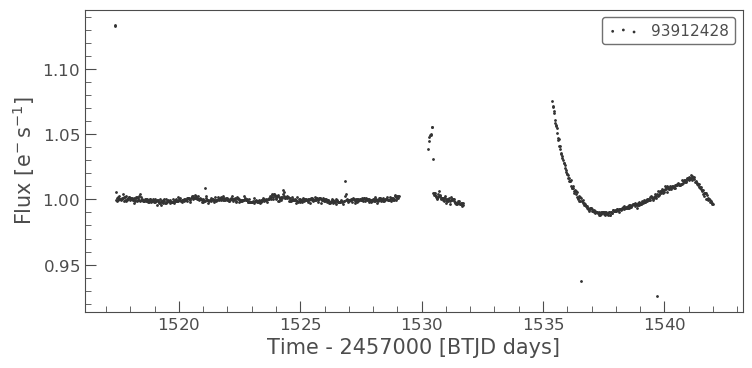

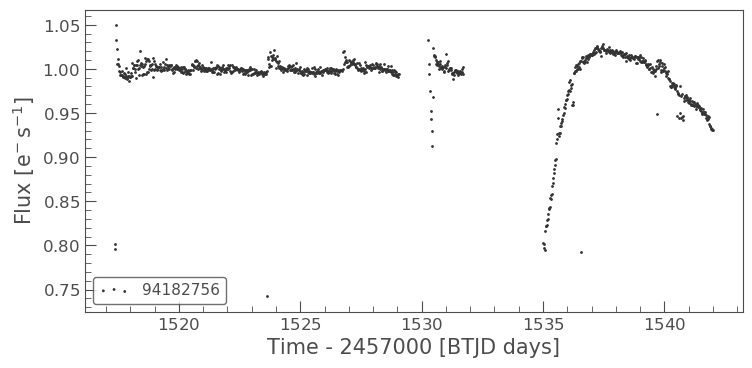

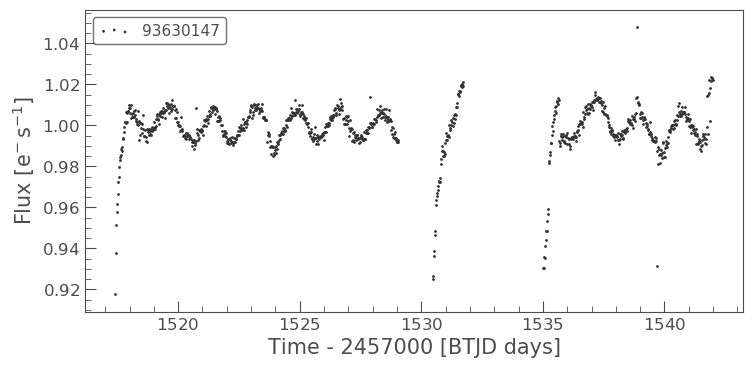

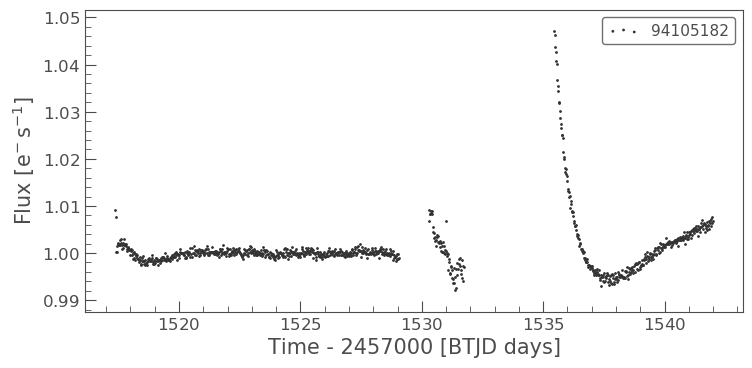

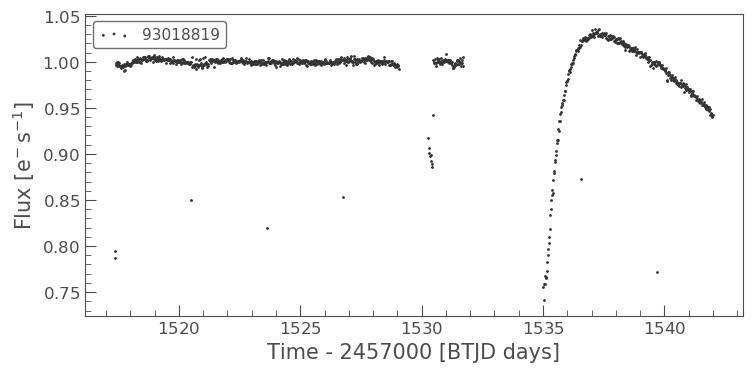

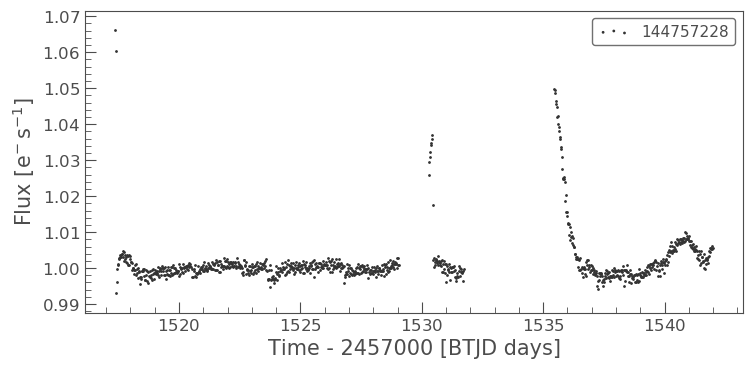

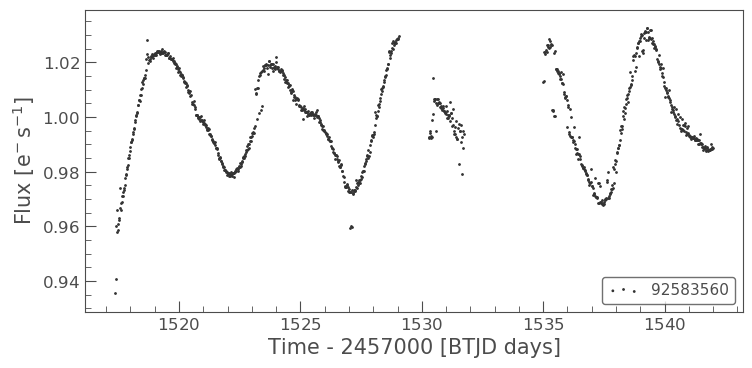

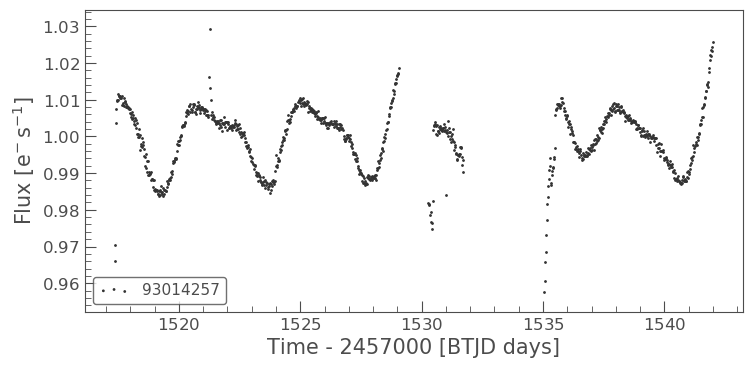

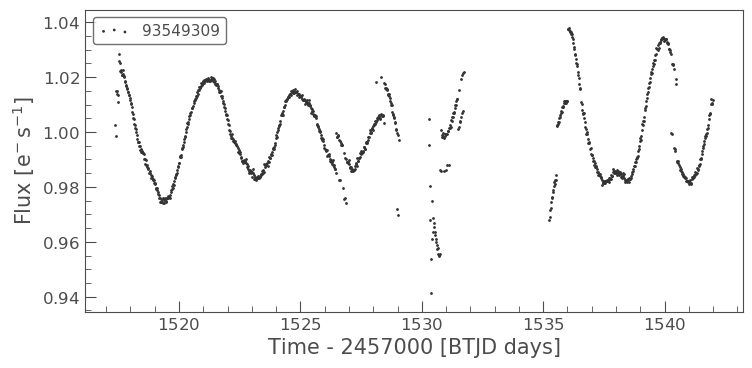

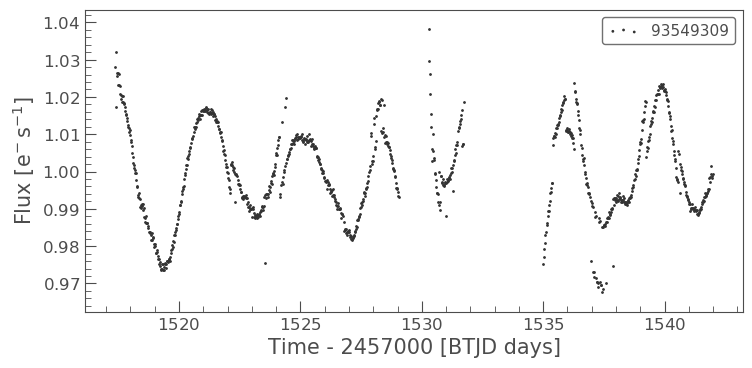

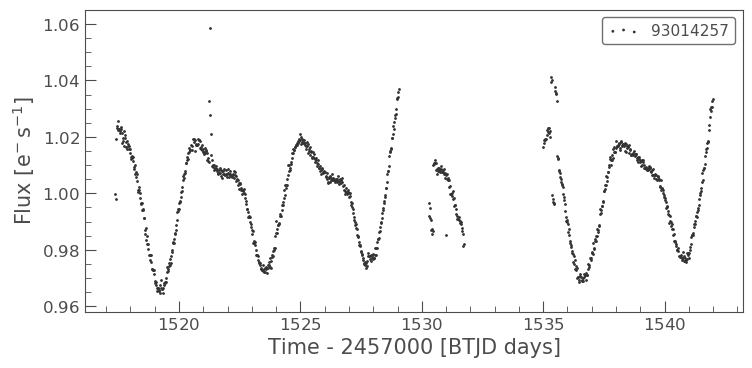

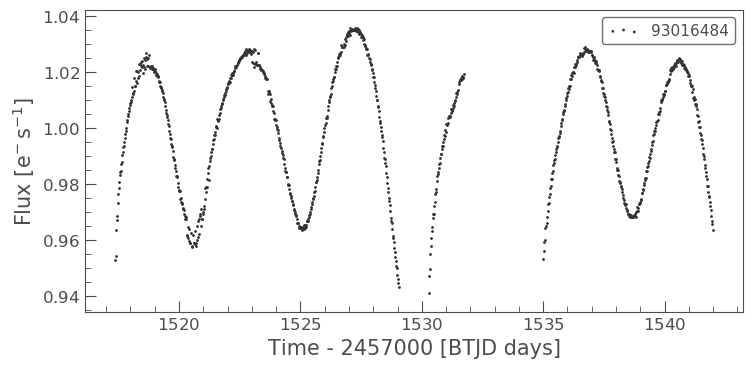

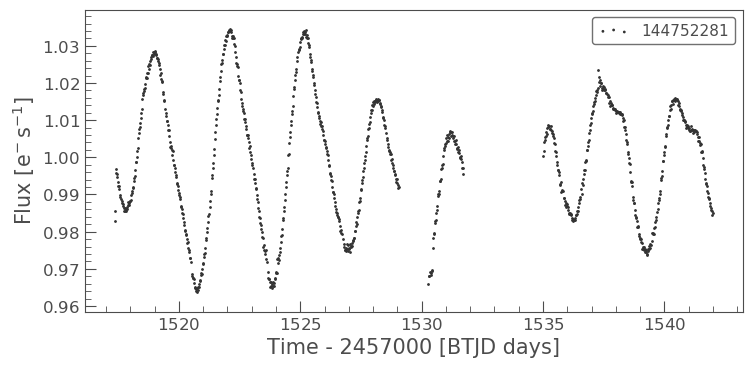

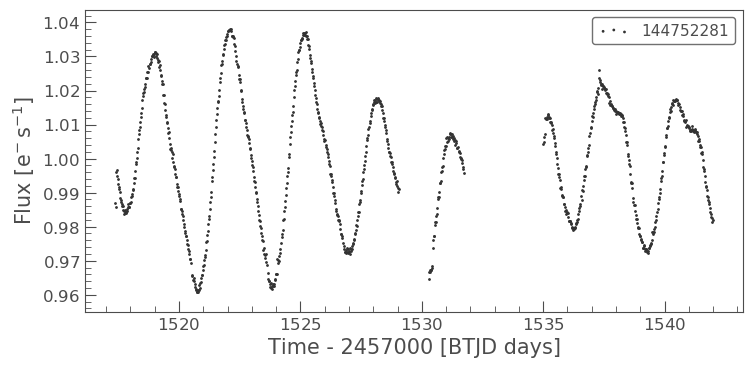

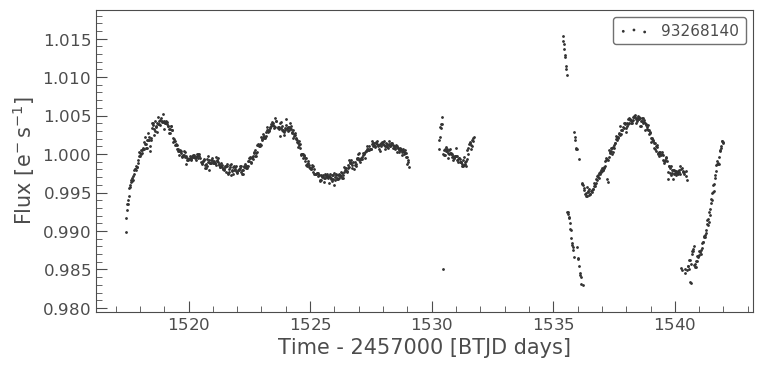

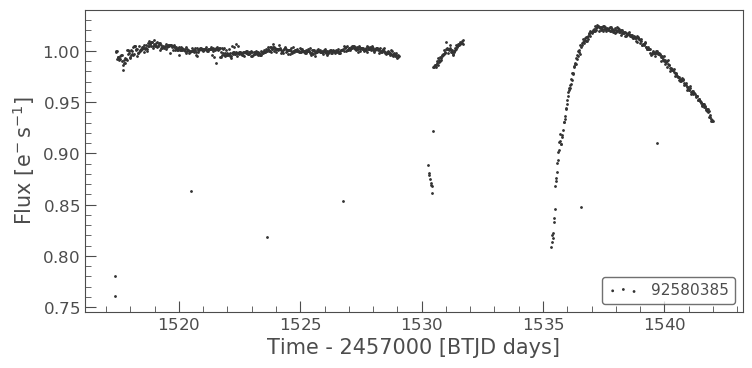

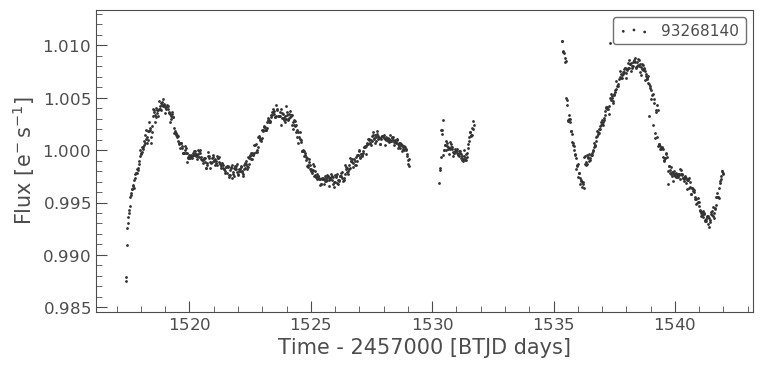

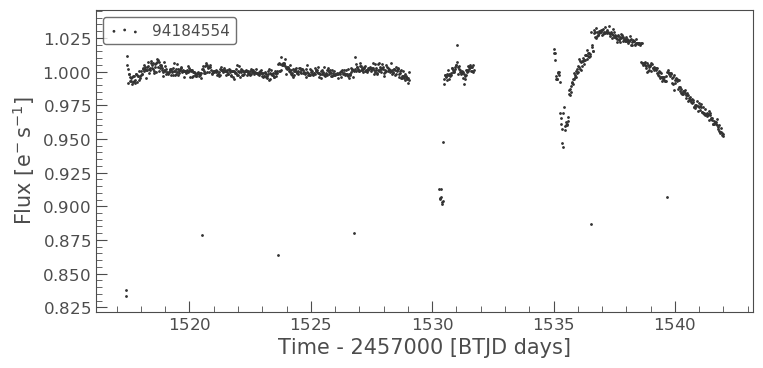

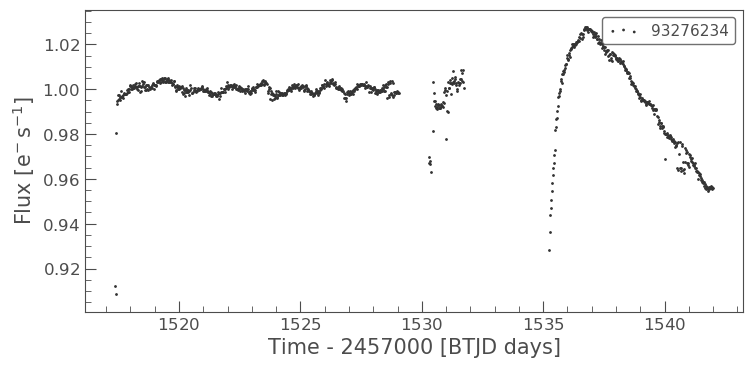

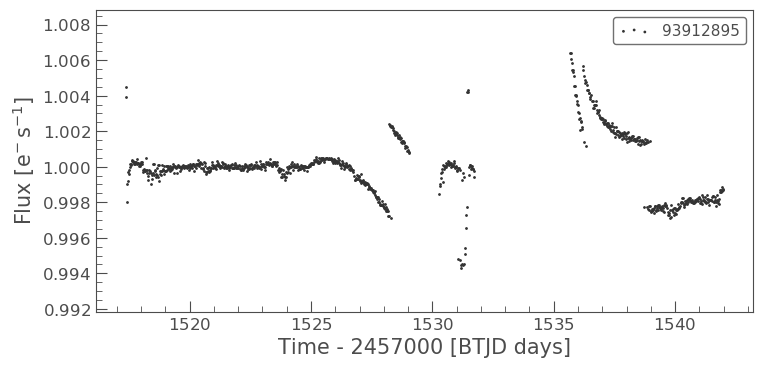

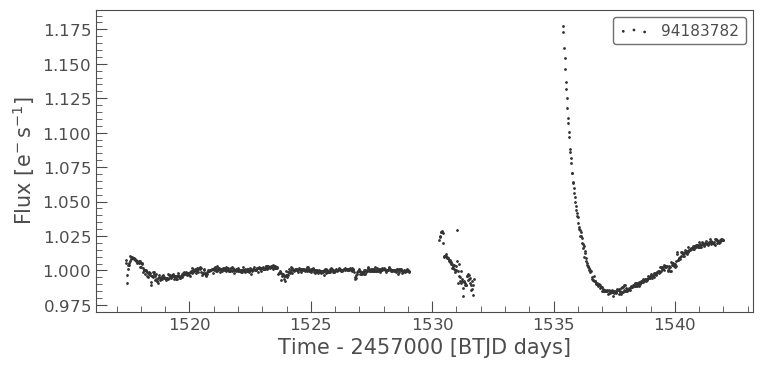

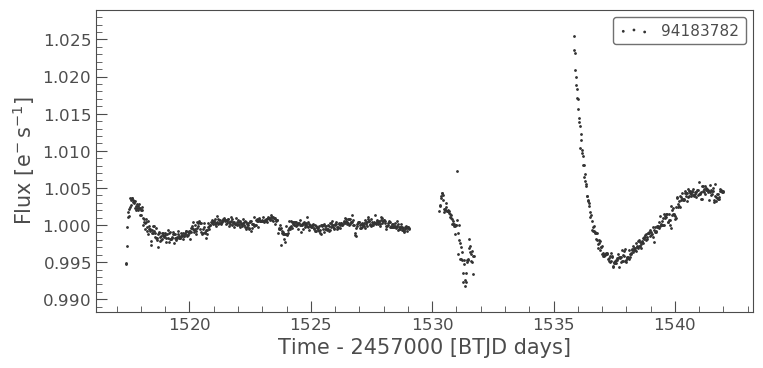

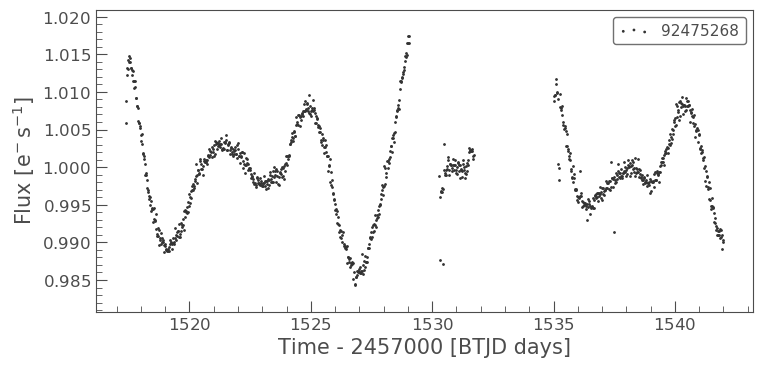

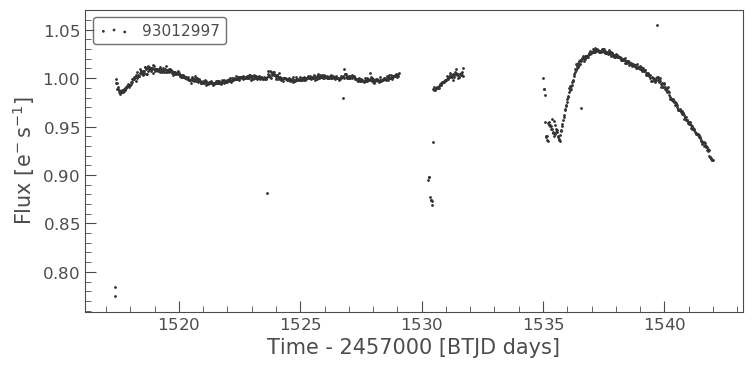

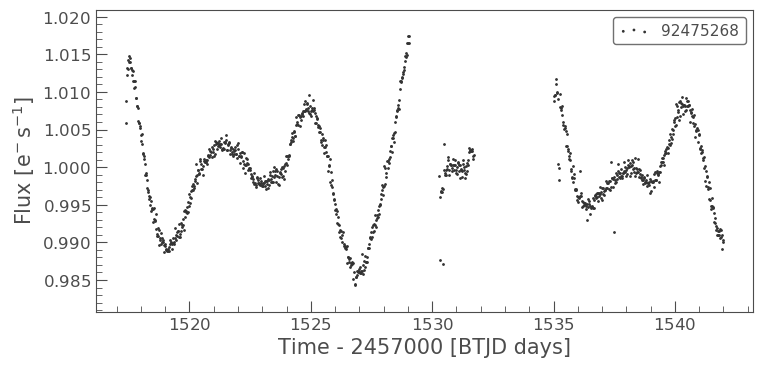

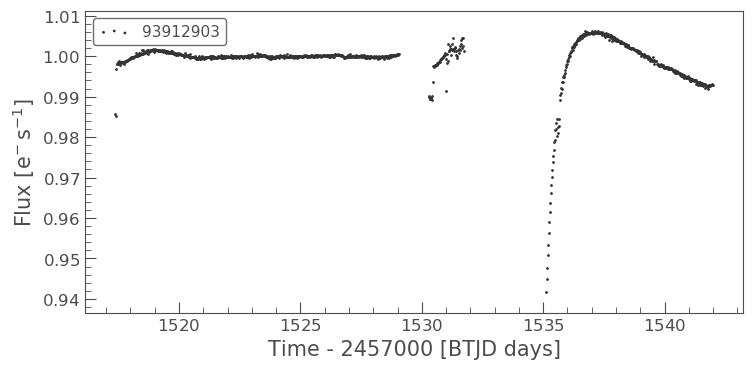

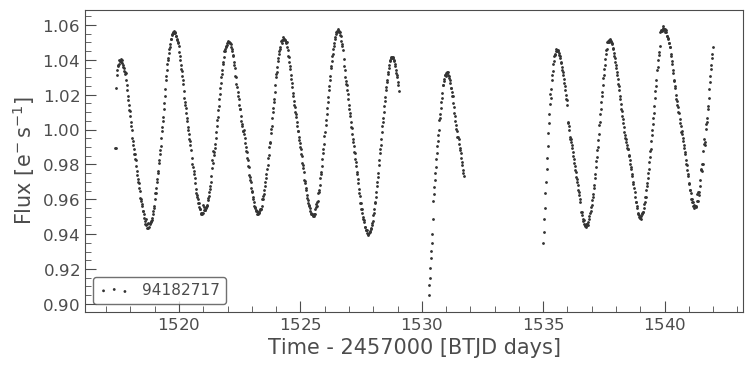

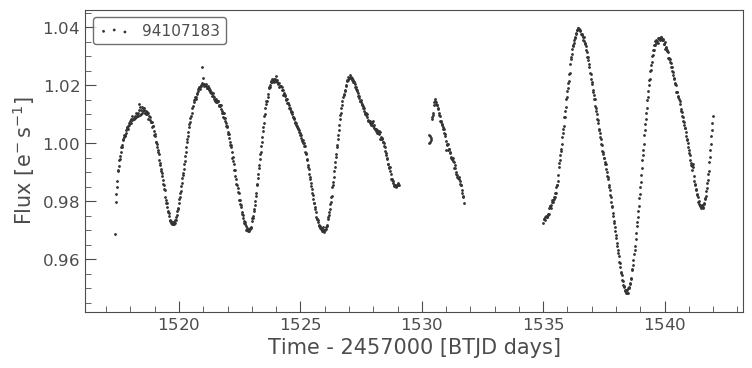

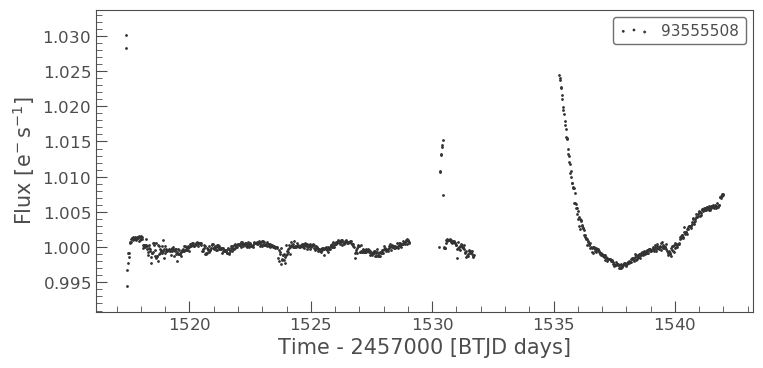

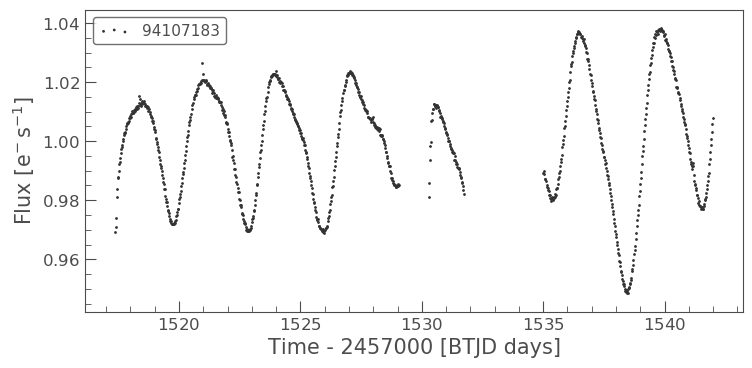

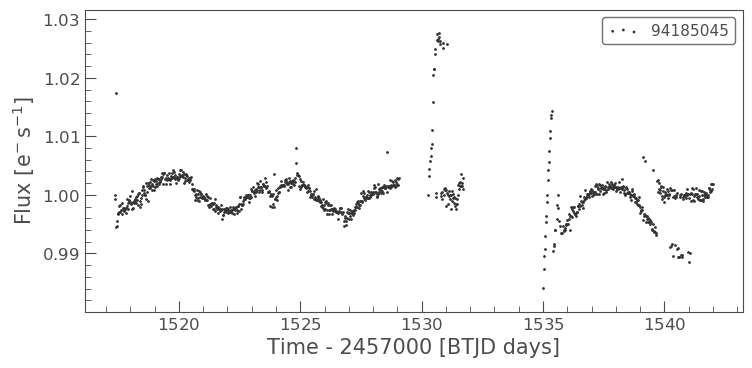

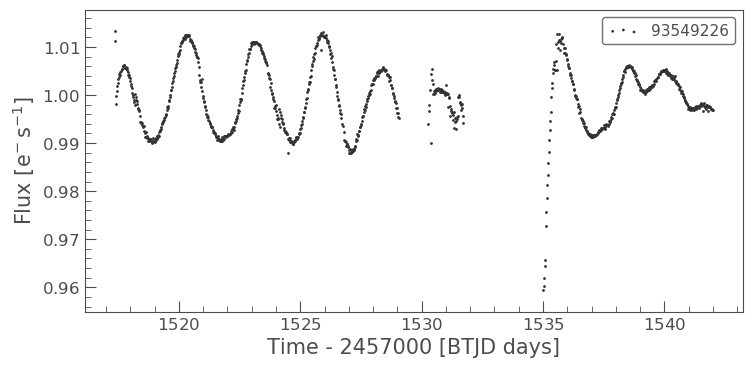

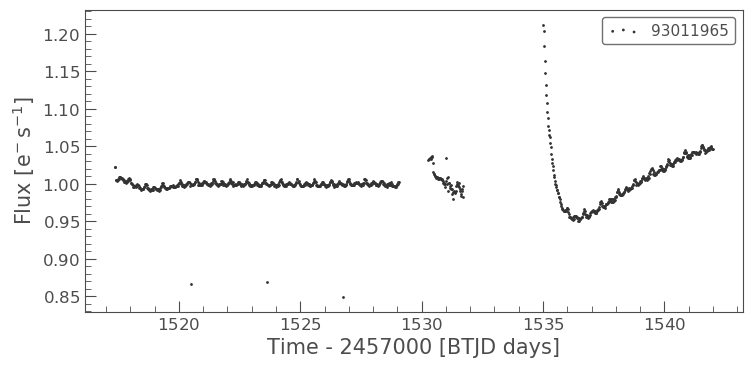

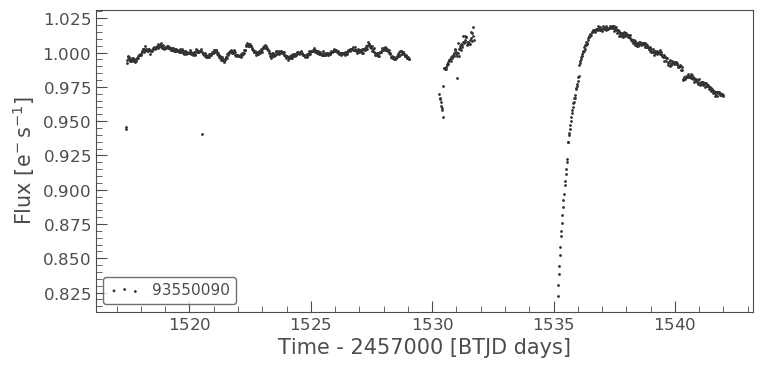

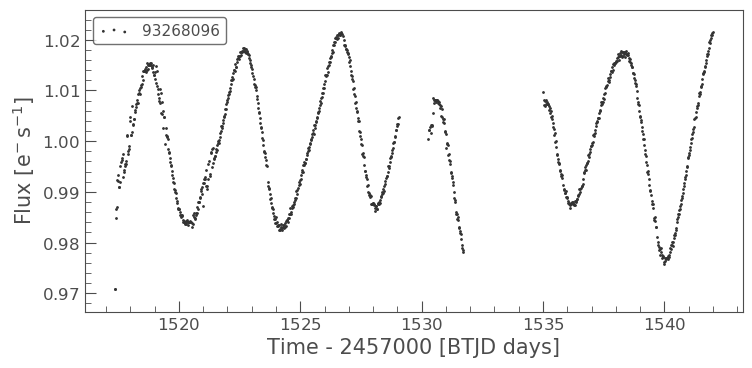

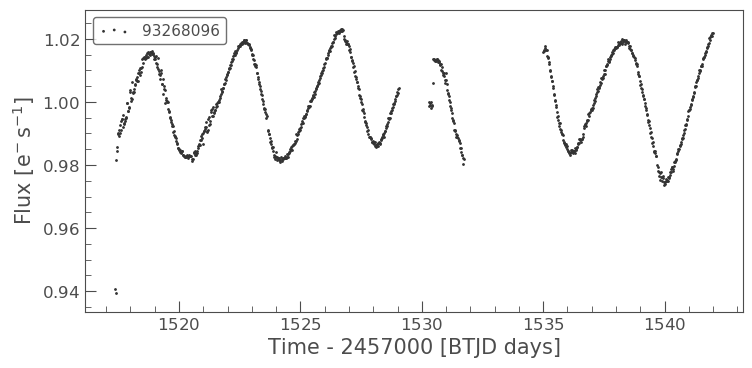

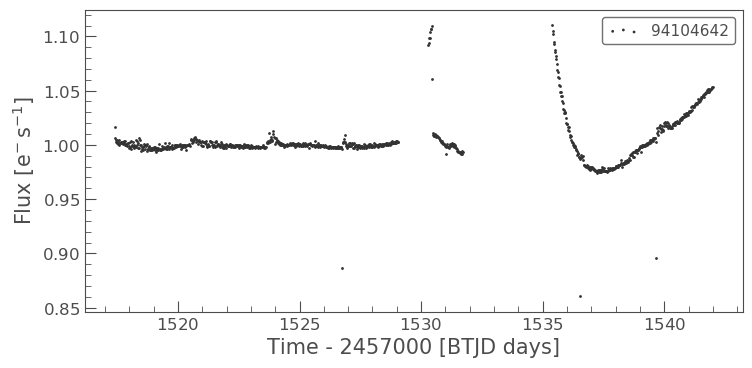

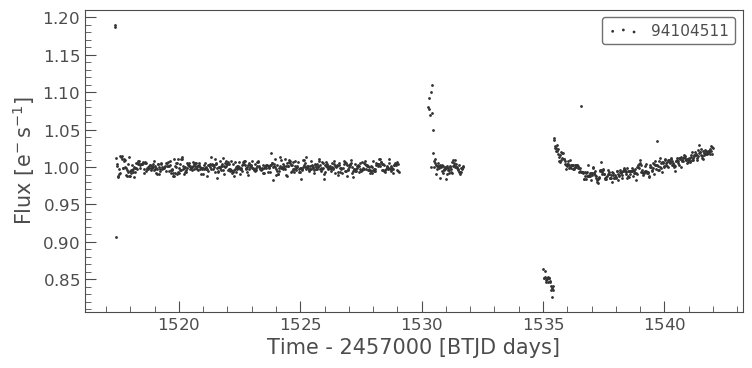

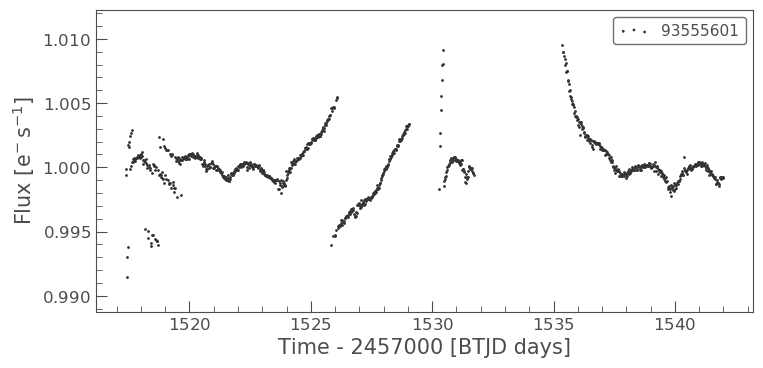

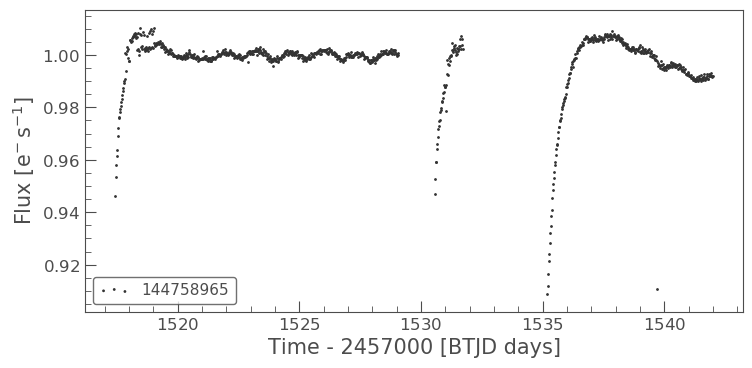

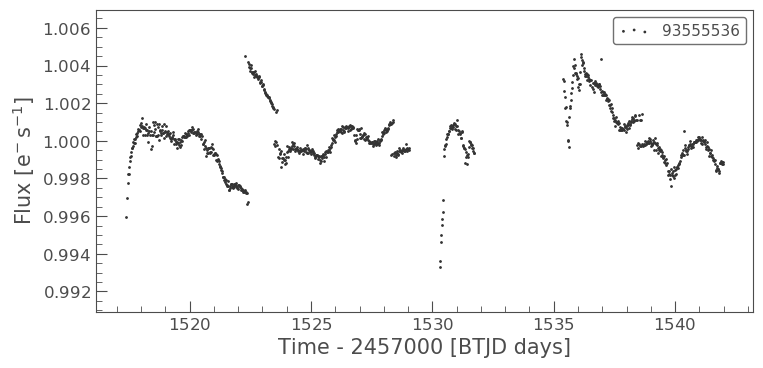

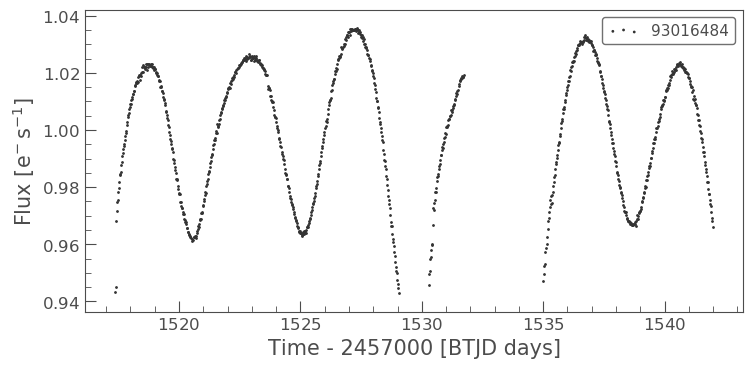

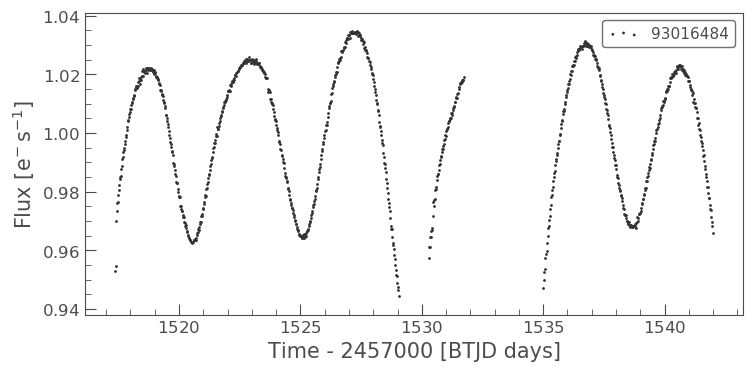

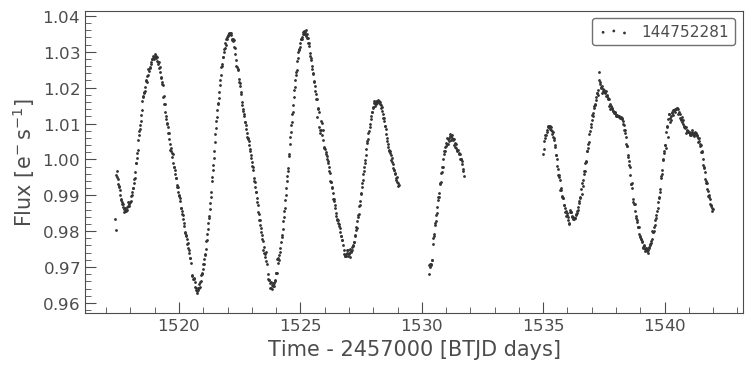

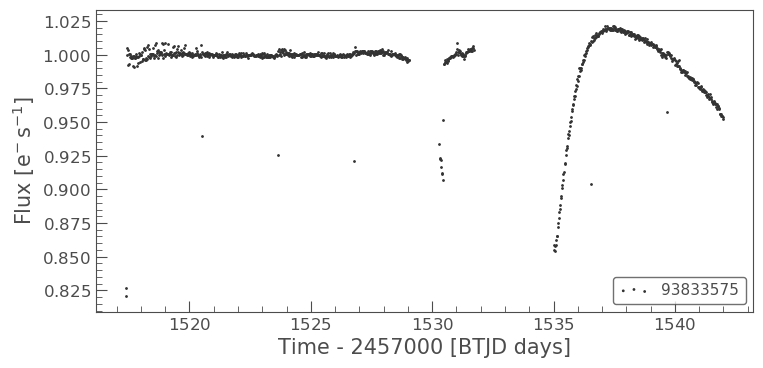

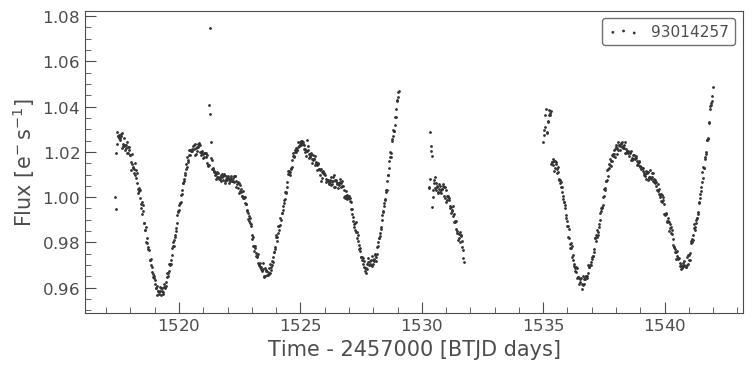

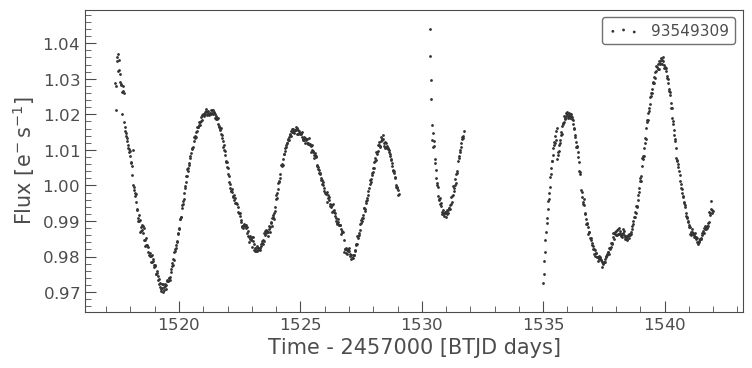

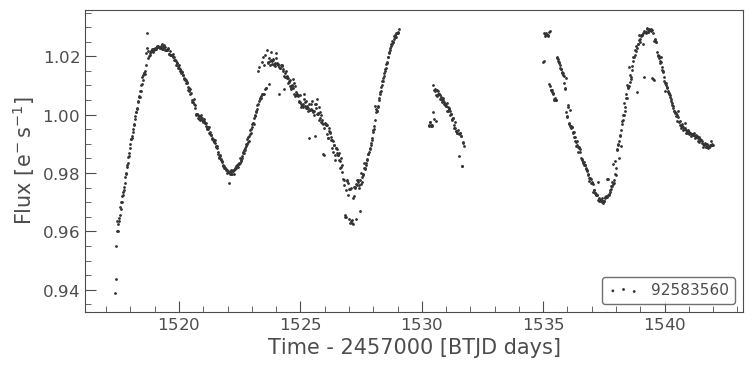

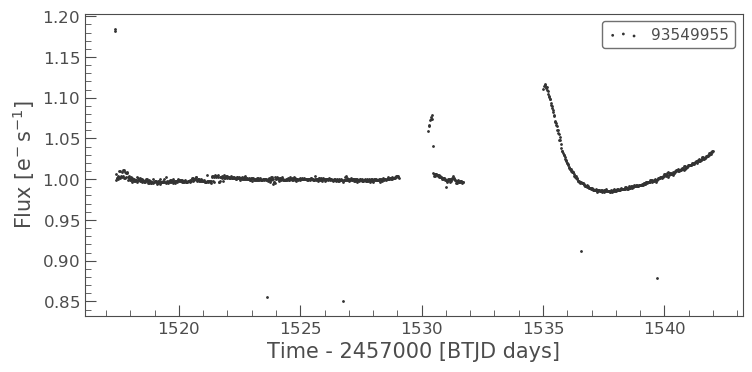

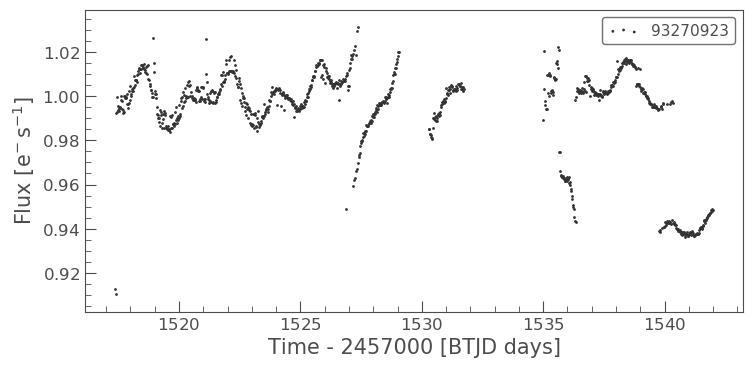

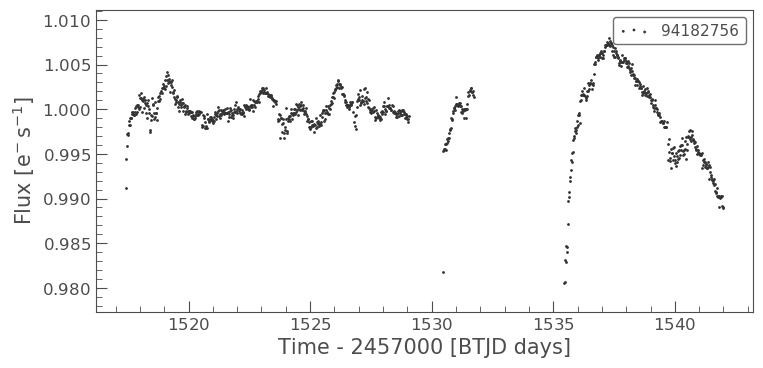

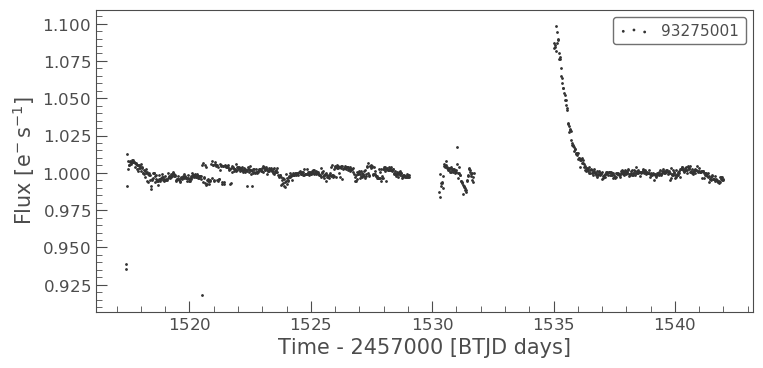

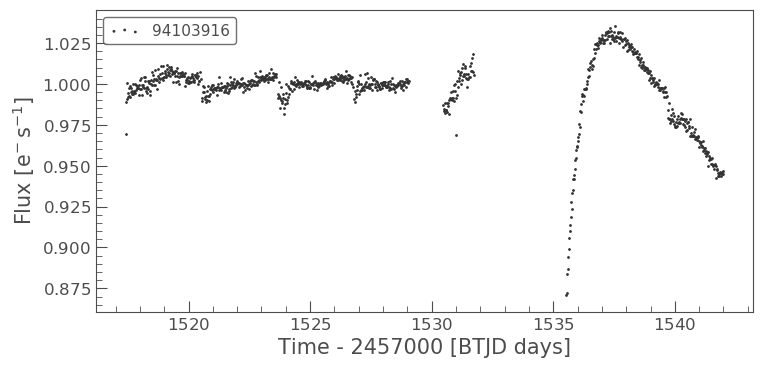

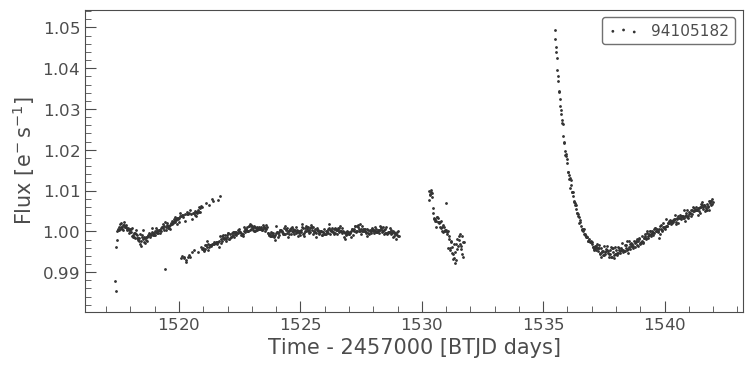

In [126]:
amplitude_top_quarter = np.percentile(amplitudes, 75)
sigmas_top_quarter = np.percentile(sigmas, 75)

indx = np.where((amplitudes > amplitude_top_quarter) & (sigmas < sigmas_top_quarter))[0]

# Get sample light curve
for index in indx:
    fits_path = fits_paths[index]

    # Import sample FITS Light Curve, remove outliers, and long term trends
    ticid, ap_type = decode_filename(fits_path)
    lcf = open_lc(fits_path)
    lc = lcf.get_lightcurve('FLUX')
    cleared_lc = lc.remove_outliers(sigma=3)
    flatten_lc, trend_lc = cleared_lc.flatten(flatten_window, return_trend=True, polyorder=2)
    flatten_lc.scatter()
    plt.show()

/Users/joseperez/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


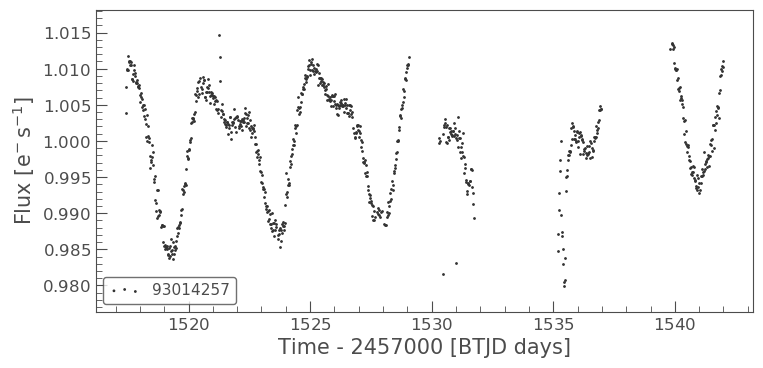

Sigma 		= 29279.3 ppm
Amplitude 	= 0.381


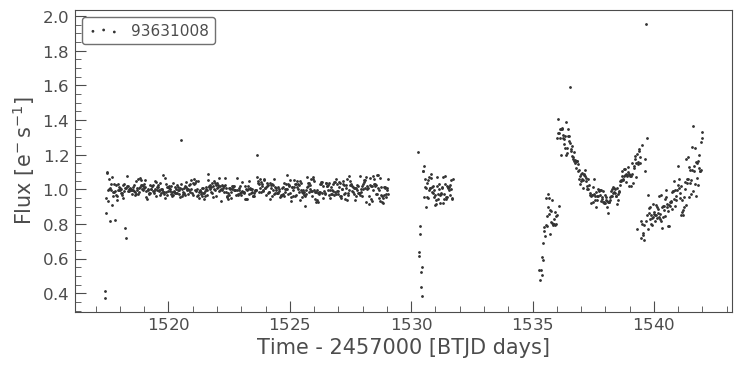

In [194]:
# Get sample light curve
fits_path = fits_paths[index[0]]

# Import sample FITS Light Curve, remove outliers, and long term trends
ticid, ap_type = decode_filename(fits_path)
lcf = open_lc(fits_path)
lc = lcf.get_lightcurve('FLUX')
cleared_lc = lc.remove_outliers(sigma=outlier_sigma)
flatten_lc, trend_lc = cleared_lc.flatten(flatten_window, return_trend=True, polyorder=2)

# Estimate Features
sigma = error_estimate(flatten_lc)
amplitude = amplitude_estimate(flatten_lc)
print(f'Sigma \t\t= {sigma:.1f} ppm')
print(f'Amplitude \t= {amplitude:.3f}')

flatten_lc.scatter()

In [74]:
# Import sample FITS Light Curve, remove outliers, and long term trends
fits_path = fits_paths[indx[0]]

ticid, ap_type = decode_filename(fits_path)
lcf = open_lc(fits_path)
lc = lcf.get_lightcurve('FLUX')
cleared_lc = lc.remove_outliers(sigma=outlier_sigma)
flatten_lc, trend_lc = cleared_lc.flatten(flatten_window, return_trend=True, polyorder=2)
    

('144997798', 'Pipeline')

/Users/joseperez/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


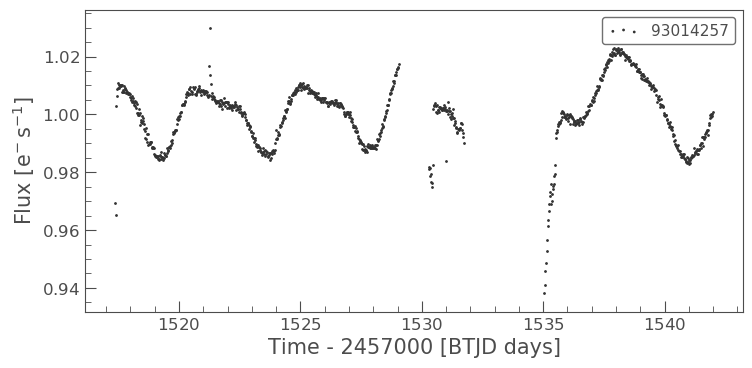

In [121]:
for fits_path in fits_paths:
    ticid, ap_type = decode_filename(fits_path)
    if ticid == '93014257':
        break
        
lcf = open_lc(fits_path)
lc = lcf.get_lightcurve('FLUX')
cleared_lc = lc.remove_outliers(sigma=3)
flatten_lc, trend_lc = cleared_lc.flatten(331, return_trend=True, polyorder=2)
flatten_lc.scatter()
plt.show()

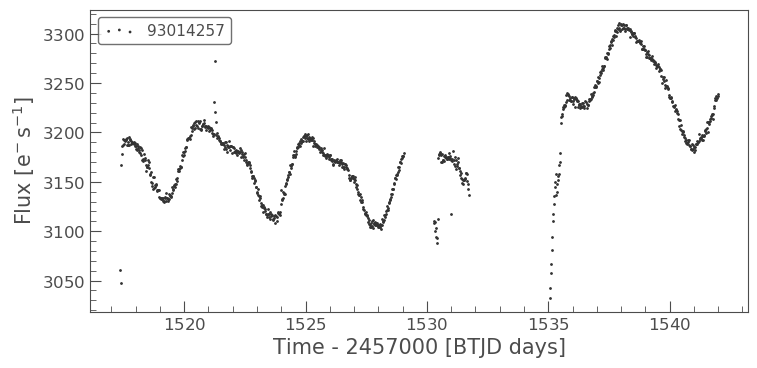

In [115]:
cleared_lc.scatter()

In [76]:
# num_terms is the number of terms for which the fourier expansion is done (how complex are the oscillations?)
num_terms = 1
# Min_period is the minimum detectable period
min_period = 0.1
# max_period is the maximum detectable period
max_period = 28.

ov_sampling = 150
un_sampling = 10

power_cutoff = 75  # percentile

outlier_sigma = 2.5

# Parameters for LS & bootstrap algorithm
threshold = 1.
prot_lims = (0.1, 28.)

In [112]:
fund_period, fund_power, periods_to_test, periodogram, aliases, sigmas = prot.run_ls(flatten_lc.time, flatten_lc.flux, flatten_lc.flux_err,
                                                                                         threshold, prot_lims=prot_lims,
                                                                                         run_bootstrap=True)

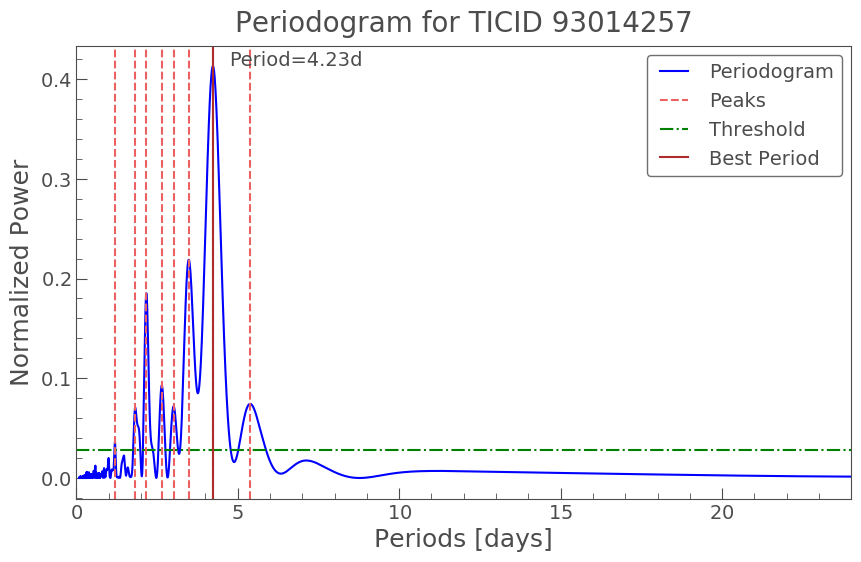

In [113]:
# Find local maxima in data; most credible periods
peaks = argrelmax(periodogram)[0]

# Remove any peak below threshold
acceptable_peaks = periodogram[peaks] > sigmas[0]
new_peaks = peaks[acceptable_peaks]
period_peaks = periods_to_test[new_peaks]

with plt.style.context(MPLSTYLE):
    fig, ax = plt.subplots(figsize=(10, 6))

    pg_curve = ax.plot(periods_to_test, periodogram, 'b-', lw=1.5)
    ax.set_xlabel('Periods [days]', fontsize=18)
    ax.set_ylabel('Normalized Power', fontsize=18)
    ax.set_title(f'Periodogram for TICID {ticid}', fontsize=20)
    threshold_line = ax.axhline(sigmas[0], color='green', linestyle='-.', lw=1.5)

    for period_peak in period_peaks:
        red_dash = ax.axvline(period_peak, ls='--', c='#eb6060', lw=1.5)  # light red shade

    main_red = ax.axvline(fund_period, c='#ad2d2d', lw=1.5)  # dark red shade

    ax.set_xlim(0, 24)
    curves = [pg_curve[0], red_dash, threshold_line, main_red]
    curve_labels = ['Periodogram', 'Peaks', 'Threshold', 'Best Period']

    ax.legend(curves, curve_labels, fontsize=14)
    ax.text(fund_period + 0.5, fund_power, rf'Period={fund_period:0.2f}d', fontsize=14)
    ax.tick_params(axis='both', labelsize=14)